# **IF features and model building**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

folder_path = "/content/drive/MyDrive/Nour/twitter"
print(f"Working with folder: {folder_path}")

Working with folder: /content/drive/MyDrive/Nour/twitter


In [ ]:
pip install pandas numpy scikit-learn joblib

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import joblib
from datetime import datetime

In [ ]:
csv_path= os.path.join(folder_path, "twitter_tsonduku.csv")
df = pd.read_csv(csv_path, parse_dates=["created_at", "user.created_at"])

/tmp/ipython-input-5-425305893.py:2: DtypeWarning: Columns (9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, parse_dates=["created_at", "user.created_at"])
/tmp/ipython-input-5-425305893.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_path, parse_dates=["created_at", "user.created_at"])
/tmp/ipython-input-5-425305893.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_path, parse_dates=["created_at", "user.created_at"])


In [ ]:
len(df)

1716726

In [ ]:
REFERENCE_DATE = datetime(2021, 7, 8)

In [ ]:
user_cols = [
    "user.id", "user.screen_name", "user.friends_count", "user.followers_count",
    "user.statuses_count", "user.created_at"
]
user_df = df[user_cols].drop_duplicates("user.id").copy()


In [ ]:
user_df["feature.ratio_friends_over_followers"] = (
    np.log1p(user_df["user.friends_count"]) / np.log1p(user_df["user.followers_count"] + 1)
)

In [ ]:
user_df["feature.n_digits_username"] = user_df["user.screen_name"].astype(str).apply(
    lambda x: sum(c.isdigit() for c in x)
)

In [ ]:
user_df["user.created_at"] = user_df["user.created_at"].dt.tz_localize(None)

In [ ]:
user_df["feature.account_age_days"] = (
    (REFERENCE_DATE - user_df["user.created_at"]).dt.days.clip(lower=1)
)

In [ ]:
user_df["feature.global_daily_rythm"] = np.log1p(user_df["user.statuses_count"]) / (
    user_df["feature.account_age_days"]
)

user_df["feature.global_follower_rythm"] = np.log1p(user_df["user.followers_count"]) / (
    user_df["feature.account_age_days"]
)

user_df["feature.global_friend_rythm"] = np.log1p(user_df["user.friends_count"]) / (
    user_df["feature.account_age_days"]
)

user_features = user_df.set_index("user.id")

In [ ]:
content_volume = df.groupby("user.id").agg(
    statuses_count=("id", "count"),
    rts_count=("is_retweet", lambda x: x.sum()),
    quotes_count=("is_quote", lambda x: x.sum()),
    replies_count=("is_reply", lambda x: x.sum())
)

user_transformed_volume = np.log1p(content_volume).add_prefix("feature.transformed_data.")

In [ ]:
df["date"] = df["created_at"].dt.date
active_days = df.groupby("user.id")["date"].nunique().rename("feature.active_days")
tweet_counts = df.groupby("user.id")["id"].count().rename("user.dataset_tweets")

daily_rythm = tweet_counts / active_days
daily_rythm.name = "feature.daily_rythm"

normalized_volume = user_transformed_volume.div(active_days, axis=0).fillna(0)

In [ ]:
def make_fake_components(df, interaction_col, prefix):
    component_labels = (
        df[df[interaction_col] == True]
        .groupby("user.id")[interaction_col]
        .count()
        .apply(lambda x: hash(x) % 5)
        .rename(f"{prefix}_component")
    )
    dummies = pd.get_dummies(component_labels, prefix=f"feature.{prefix}_component")
    return dummies


In [ ]:
retweet_components = make_fake_components(df, "is_retweet", "retweet")
quote_components = make_fake_components(df, "is_quote", "quote")
reply_components = make_fake_components(df, "is_reply", "reply")

In [ ]:
all_features = (
    user_features
    .join(user_transformed_volume, how="left")
    .join(normalized_volume, rsuffix="_normalized", how="left")
    .join(active_days, how="left")
    .join(daily_rythm, how="left")
    .join(retweet_components, how="left")
    .join(quote_components, how="left")
    .join(reply_components, how="left")
)

feature_matrix = (
    all_features
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
)


In [ ]:
model = IsolationForest(
    n_estimators=100,
    max_samples=1000,
    contamination="auto",
    max_features=1.0,
    n_jobs=2,
    random_state=666,
    verbose=1
)

In [ ]:

non_feature_cols = ["user.screen_name", "user.created_at"]
feature_matrix = feature_matrix.drop(columns=[col for col in non_feature_cols if col in feature_matrix.columns])

feature_matrix = feature_matrix.apply(pd.to_numeric, errors="coerce").fillna(0)

In [ ]:
feature_matrix

,user.friends_count,user.followers_count,user.statuses_count,feature.ratio_friends_over_followers,feature.n_digits_username,feature.account_age_days,feature.global_daily_rythm,feature.global_follower_rythm,feature.global_friend_rythm,feature.transformed_data.statuses_count,...,feature.quote_component_0,feature.quote_component_1,feature.quote_component_2,feature.quote_component_3,feature.quote_component_4,feature.reply_component_0,feature.reply_component_1,feature.reply_component_2,feature.reply_component_3,feature.reply_component_4
user.id,,,,,,,,,,,,,,,,,,,,,
467108258,5640,5125,9393,1.011184,2,660,0.013860,0.012943,0.013088,4.736198,...,0,1,0,0,0,0,0,1,0,0
691055830,25581,55979,186527,0.928369,0,1273,0.009534,0.008588,0.007973,6.135565,...,0,1,0,0,0,0,0,1,0,0
324604086,86229,87096,338848,0.999119,2,2066,0.006163,0.005506,0.005501,5.958425,...,0,0,0,0,1,0,0,0,0,1
745737780,56019,78102,333829,0.970501,0,1624,0.007832,0.006937,0.006732,6.045005,...,0,1,0,0,0,0,0,1,0,0
188042693,47128,56883,385838,0.982816,0,3781,0.003402,0.002896,0.002846,6.440947,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829534362,505,505,16145,0.999683,0,3634,0.002666,0.001713,0.001713,1.945910,...,0,0,0,1,0,0,0,0,0,0
416042737,6511,5971,115427,1.009936,0,4468,0.002609,0.001946,0.001965,4.219508,...,0,1,0,0,0,0,0,0,0,1
655271621,1186,487,33662,1.143212,0,3630,0.002872,0.001705,0.001950,3.044522,...,0,1,0,0,0,0,0,0,1,0


In [ ]:
feature_matrix.columns

Index(['user.friends_count', 'user.followers_count', 'user.statuses_count',
       'feature.ratio_friends_over_followers', 'feature.n_digits_username',
       'feature.account_age_days', 'feature.global_daily_rythm',
       'feature.global_follower_rythm', 'feature.global_friend_rythm',
       'feature.transformed_data.statuses_count',
       'feature.transformed_data.rts_count',
       'feature.transformed_data.quotes_count',
       'feature.transformed_data.replies_count',
       'feature.transformed_data.statuses_count_normalized',
       'feature.transformed_data.rts_count_normalized',
       'feature.transformed_data.quotes_count_normalized',
       'feature.transformed_data.replies_count_normalized',
       'feature.active_days', 'feature.daily_rythm',
       'feature.retweet_component_0', 'feature.retweet_component_1',
       'feature.retweet_component_2', 'feature.retweet_component_3',
       'feature.retweet_component_4', 'feature.quote_component_0',
       'feature.quote_comp

In [ ]:
len(feature_matrix.columns)

36

In [ ]:

model.fit(feature_matrix)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished


IsolationForest(max_samples=1000, n_jobs=2, random_state=666, verbose=1)

In [ ]:
feature_matrix["anomaly.score"] = model.decision_function(feature_matrix)
feature_matrix["anomaly.label"] = feature_matrix["anomaly.score"].apply(
    lambda x: "anomalous" if x < 0 else "normal"
)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


In [ ]:
output = feature_matrix[["anomaly.score", "anomaly.label"]].reset_index()
output.to_csv("user_anomaly_scores.csv", index=False)


In [ ]:
df_scores=pd.read_csv('user_anomaly_scores.csv')

In [ ]:
df_scores.head(20)

,user.id,anomaly.score,anomaly.label
0,467108258,-0.021331,anomalous
1,691055830,-0.055969,anomalous
2,324604086,-0.108523,anomalous
3,745737780,-0.084872,anomalous
4,188042693,-0.057725,anomalous
5,679114618,-0.036466,anomalous
6,727086492,-0.019422,anomalous
7,660818840,0.016443,normal
8,76280157,0.026248,normal
9,968802777,-0.005571,anomalous


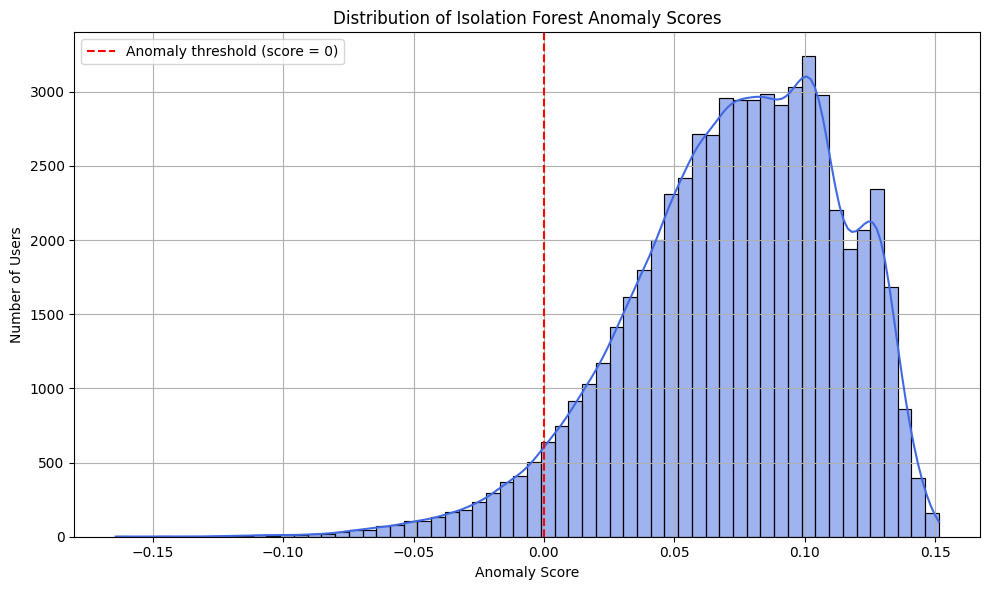

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(feature_matrix["anomaly.score"], bins=60, kde=True, color="royalblue")

# Decision threshold line
plt.axvline(x=0, color="red", linestyle="--", label="Anomaly threshold (score = 0)")

plt.title("Distribution of Isolation Forest Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Number of Users")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
feature_matrix["anomaly.score"].min()

-0.16425925925990514

/tmp/ipython-input-29-182155028.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="anomaly.label", data=feature_matrix.reset_index(), palette="Set2")


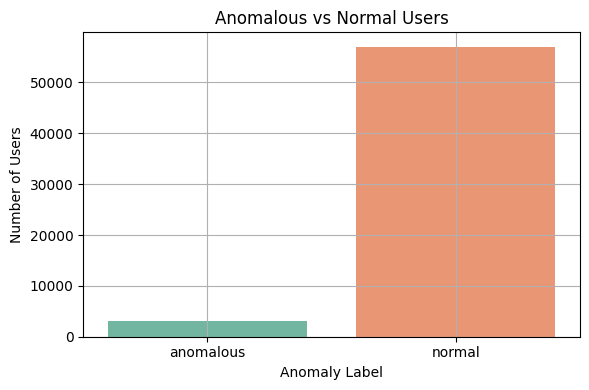

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x="anomaly.label", data=feature_matrix.reset_index(), palette="Set2")
plt.title("Anomalous vs Normal Users")
plt.xlabel("Anomaly Label")
plt.ylabel("Number of Users")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("🔎 Distribution of anomaly labels:")
print(feature_matrix["anomaly.label"].value_counts())

🔎 Distribution of anomaly labels:
anomaly.label
normal       57009
anomalous     3018
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

cleaned_features = (
    feature_matrix.drop(columns=["anomaly.score", "anomaly.label"], errors="ignore")
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
)

scaler = RobustScaler()
scaled_features = scaler.fit_transform(cleaned_features)

model = IsolationForest(
    n_estimators=300,
    max_samples='auto',
    contamination=0.04,
    max_features=1,
    n_jobs=-1,
    random_state=666,
    verbose=1
)
model.fit(scaled_features)

scores = model.decision_function(scaled_features)
# labels = ["anomalous" if s < 0 else "normal" for s in scores]
threshold = np.percentile(scores, 4)
labels = ["anomalous" if s < threshold else "normal" for s in scores]

# Step 6: Store results
feature_matrix["anomaly.score"] = scores
feature_matrix["anomaly.label"] = labels

output = feature_matrix[["anomaly.score", "anomaly.label"]].reset_index()

/tmp/ipython-input-875271331.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[bool_cols] = df[bool_cols].astype(int)
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.9s remaining:    2.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.8s finished


In [ ]:
def get_post_type(row):
    if row["is_retweet"]:
        return "Retweet"
    elif row["is_quote"]:
        return "Quote"
    elif row["is_reply"]:
        return "Reply"
    else:
        return "Original"

df_labeled = df.merge(
    feature_matrix["anomaly.label"], left_on="user.id", right_index=True, how="left"
)
df_labeled["post_type"] = df_labeled.apply(get_post_type, axis=1)
def assign_label(row):
    if row["user.type"] == "suspended":
        return "Suspended"
    elif row["user.type"] == "deleted":
        return "Deleted"
    elif row["anomaly.label"] == "anomalous":
        return "Bot"
    else:
        return "Other"
df_labeled["final_label"] = df_labeled.apply(assign_label, axis=1)
summary = df_labeled.groupby(["post_type", "final_label"]).size().unstack(fill_value=0)
summary.loc["Total"] = summary.sum()
summary["Total (%)"] = (summary.loc["Total"] / summary.loc["Total"].sum() * 100).round(2)

# Display result
summary = summary[["Bot", "Suspended", "Deleted", "Other"]]

# **Agreement score calculation**

In [ ]:
def get_post_label(row):
    if row["user.type"] == "suspended":
        return "suspended"
    elif row["user.type"] == "deleted":
        return "deleted"
    elif row["anomaly.label"] == "anomalous":
        return "bot"
    else:
        return "other"

df_labeled["post_type"] = df_labeled.apply(get_post_label, axis=1)

# --- Select required columns and export to CSV ---
IF_df = df_labeled[["id", "post_type"]]
# csv_path = os.path.join(folder_path,"If_classified_posts.csv")
# post_classification.to_csv(csv_path, index=False)

In [ ]:
botometer_df=pd.read_csv("/content/drive/MyDrive/Nour/twitter/Botometer_classified_posts.csv")

In [ ]:
botometer_df = botometer_df.rename(columns={"post_type": "botometer"})
IF_df = IF_df.rename(columns={"post_type": "IF"})

In [ ]:
merged_df = pd.merge(botometer_df, IF_df, on="id", how="inner")

In [ ]:
merged_df["IF"] = merged_df["IF"].apply(lambda x: 1 if x == "bot" else 0)
merged_df["botometer"] = merged_df["botometer"].apply(lambda x: 1 if x == "bot" else 0)

In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(merged_df['botometer'], merged_df['IF'])

print(f"Cohen's Kappa agreement score: {kappa:.4f}")
#  0.3497

Cohen's Kappa agreement score: 0.3497


In [ ]:
from sklearn.metrics import confusion_matrix

# Get raw values
y_true = merged_df['botometer']
y_pred = merged_df['IF']

# Compute confusion matrix: returns [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Print results
print("True Positives (TP):", tp)
print("False Positives (FP):", fp)
print("True Negatives (TN):", tn)
print("False Negatives (FN):", fn)

# Optional: accuracy, precision, recall
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"Total number: {len(merged_df)}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

True Positives (TP): 180489
False Positives (FP): 271743
True Negatives (TN): 1152005
False Negatives (FN): 112489
Total number: 1716726
Accuracy: 0.7762
Recall: 0.6160
Precision: 0.3991


# **Manual evaluation for 100 samples**

In [ ]:
boto_If= pd.read_csv("/content/drive/MyDrive/Nour/twitter/Botometer_VS_IF.csv")

In [ ]:
ids_with_botometer_1 = boto_If[boto_If['botometer'] == 1]['id'].tolist()

In [ ]:
just_bot_ID_df = df[df['id'].isin(ids_with_botometer_1)]

In [ ]:
df_labeled = just_bot_ID_df.merge(
    feature_matrix[["anomaly.score", "anomaly.label"]],
    left_on="user.id",
    right_index=True,
    how="left"
)

In [ ]:
df_labeled

,id,text,created_at,lang,entities.urls,entities.user_mentions,entities.hashtags,user.id,user.description,user.location,...,in_reply_to_user_id,in_reply_to_status_id,quote.id,quote.user.id,rt.id,rt.user.id,user.type,date,anomaly.score,anomaly.label
0,1267443579045232651,During all those protests people suddenly forg...,2020-06-01 13:11:11+00:00,en,https://twitter.com/IllinoisJack85/status/1267...,NaN,NaN,467108258,"""Thou shalt not follow a multitude to do evil""...","Mattoon, Illinois",...,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,bot,2020-06-01,-0.021331,anomalous
1,1267520253904510976,I just saw CBSN doing a POSITIVE report on Hyd...,2020-06-01 18:15:52+00:00,en,https://twitter.com/IllinoisJack85/status/1267...,NaN,NaN,467108258,"""Thou shalt not follow a multitude to do evil""...","Mattoon, Illinois",...,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,bot,2020-06-01,-0.021331,anomalous
2,1267587387443593217,Who died and made you king? https://t.co/Phi4R...,2020-06-01 22:42:38+00:00,en,https://twitter.com/IllinoisJack85/status/1267...,NaN,NaN,467108258,"""Thou shalt not follow a multitude to do evil""...","Mattoon, Illinois",...,NaN,NaN,0.000000e+00,0.000000e+00,1260576861228236802,2.312526e+07,bot,2020-06-01,-0.021331,anomalous
3,1267840580299694082,Because the good guys aren't finished yet,2020-06-02 15:28:44+00:00,en,https://twitter.com/IllinoisJack85/status/1267...,NaN,NaN,467108258,"""Thou shalt not follow a multitude to do evil""...","Mattoon, Illinois",...,NaN,NaN,1.267840e+18,9.330894e+17,1267840224446554112,9.330894e+17,bot,2020-06-02,-0.021331,anomalous
4,1267887896884908032,@alaphiah I said that too when I realized no o...,2020-06-02 18:36:45+00:00,en,https://twitter.com/IllinoisJack85/status/1267...,NaN,NaN,467108258,"""Thou shalt not follow a multitude to do evil""...","Mattoon, Illinois",...,1.979064e+07,1.267886e+18,0.000000e+00,0.000000e+00,NaN,NaN,bot,2020-06-02,-0.021331,anomalous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292973,1277995632142233600,@TheLeoTerrell @seanhannity @FoxNews Not so su...,2020-06-30 16:01:17+00:00,en,https://twitter.com/Sueen9/status/127799563214...,NaN,NaN,186829347,https://t.co/WWlhj6pPfe.MAGA Lost account.. pl...,NaN,...,1.212806e+18,1.277775e+18,0.000000e+00,0.000000e+00,NaN,NaN,bot,2020-06-30,0.005577,normal
292974,1277997653926780930,@groth1945 @neuro7plastic And they allowed pro...,2020-06-30 16:09:19+00:00,en,https://twitter.com/Sueen9/status/127799765392...,NaN,NaN,186829347,https://t.co/WWlhj6pPfe.MAGA Lost account.. pl...,NaN,...,9.051533e+17,1.277944e+18,0.000000e+00,0.000000e+00,NaN,NaN,bot,2020-06-30,0.005577,normal
292975,1268392641135177728,Leftist Socialists closed @HouseDemocrats for ...,2020-06-04 04:02:25+00:00,en,https://twitter.com/TexanAlliKat/status/126839...,NaN,NaN,919898383,🇺🇸⚓️US Navy Veteran Native Texan Proud Trump S...,United States,...,NaN,NaN,0.000000e+00,0.000000e+00,1268375189290577922,9.347984e+17,bot,2020-06-04,0.076150,normal
292976,1268711421769953280,@TexanAlliKat @WadePerkins12 I am going to kee...,2020-06-05 01:09:09+00:00,en,https://twitter.com/TexanAlliKat/status/126871...,NaN,NaN,919898383,🇺🇸⚓️US Navy Veteran Native Texan Proud Trump S...,United States,...,NaN,NaN,0.000000e+00,0.000000e+00,{'created_at': 'Thu Jun 04 05:43:30 +0000 2020...,1.619985e+08,bot,2020-06-05,0.076150,normal


In [ ]:
feature_matrix.columns

Index(['user.friends_count', 'user.followers_count', 'user.statuses_count',
       'feature.ratio_friends_over_followers', 'feature.n_digits_username',
       'feature.account_age_days', 'feature.global_daily_rythm',
       'feature.global_follower_rythm', 'feature.global_friend_rythm',
       'feature.transformed_data.statuses_count',
       'feature.transformed_data.rts_count',
       'feature.transformed_data.quotes_count',
       'feature.transformed_data.replies_count',
       'feature.transformed_data.statuses_count_normalized',
       'feature.transformed_data.rts_count_normalized',
       'feature.transformed_data.quotes_count_normalized',
       'feature.transformed_data.replies_count_normalized',
       'feature.active_days', 'feature.daily_rythm',
       'feature.retweet_component_0', 'feature.retweet_component_1',
       'feature.retweet_component_2', 'feature.retweet_component_3',
       'feature.retweet_component_4', 'feature.quote_component_0',
       'feature.quote_comp

In [ ]:
anomalous_df = df_labeled[df_labeled["anomaly.label"] == "anomalous"].copy()

In [ ]:
anomalous_df = anomalous_df.drop_duplicates(subset="user.id")

In [ ]:
most_anomalous = anomalous_df.nsmallest(35, "anomaly.score")
least_anomalous = anomalous_df.nlargest(35, "anomaly.score")
borderline_range = anomalous_df[
    anomalous_df["anomaly.score"].between(-0.08, -0.04)
].sample(n=30, random_state=42)

In [ ]:
eval_samples = pd.concat([most_anomalous, borderline_range, least_anomalous])
eval_samples = eval_samples.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
eval_samples.head(5)

,id,text,created_at,lang,entities.urls,entities.user_mentions,entities.hashtags,user.id,user.description,user.location,...,in_reply_to_user_id,in_reply_to_status_id,quote.id,quote.user.id,rt.id,rt.user.id,user.type,date,anomaly.score,anomaly.label
0,1267264224222277632,@realDonaldTrump Before Covid-19 there were ma...,2020-06-01 01:18:30+00:00,en,https://twitter.com/RL9631/status/126726422422...,NaN,NaN,385653564,Wife~Mother~🇺🇸Day1TrumpSupporter~🇺🇸2016 AZ Rep...,United States,...,NaN,NaN,0.000000e+00,0.000000e+00,{'created_at': 'Sun May 31 23:19:25 +0000 2020...,1.186159e+18,bot,2020-06-01,-0.000934,anomalous
1,1267817283872714755,If Dems had told us they were planning this bi...,2020-06-02 13:56:10+00:00,en,https://twitter.com/MamaD15718191/status/12678...,NaN,NaN,82202334,Believer. Wife. Mother. Grandmother. Conservat...,"Georgia, USA",...,NaN,NaN,1.267482e+18,2.178495e+07,1267482191388446720,2.178495e+07,bot,2020-06-02,-0.052266,anomalous
2,1270128390297640961,@realDonaldTrump Drs. get brought before the m...,2020-06-08 22:59:40+00:00,en,https://twitter.com/lewschreck/status/12701283...,NaN,NaN,110537523,NaN,NaN,...,25073877.0,NaN,1.270106e+18,7.820182e+17,1270105893082992641,7.820182e+17,bot,2020-06-08,-0.000278,anomalous
3,1275797429737021440,Amid the coronavirus pandemic and trade tensio...,2020-06-24 14:26:25+00:00,en,https://twitter.com/AussieVal10/status/1275797...,NaN,NaN,604675973,"Family, God, Freedom - #MAGA #KAG #WWG1WGA Aus...",Australia,...,NaN,NaN,0.000000e+00,0.000000e+00,{'created_at': 'Wed Jun 24 13:02:34 +0000 2020...,1.683466e+07,bot,2020-06-24,-0.048595,anomalous
4,1267284280834576387,Is anyone wondering any longer why all the cri...,2020-06-01 02:38:12+00:00,en,https://twitter.com/HelloTeamTrump/status/1267...,NaN,NaN,446184975,❌❌❌❌#ENDHOAAbuse #fraudinamerica #epidemic #re...,AMERICA USA,...,NaN,NaN,0.000000e+00,0.000000e+00,{'created_at': 'Mon Jun 01 02:37:49 +0000 2020...,1.013291e+18,bot,2020-06-01,-0.073765,anomalous


In [ ]:
csv_path= os.path.join(folder_path, "IF_manual_eval_samples.csv")
eval_samples.to_csv(csv_path, index=False)

In [ ]:
df_eval_with_features = eval_samples.merge(
    feature_matrix.reset_index(),
    on="user.id",
    how="left"
)

In [ ]:
df_eval_with_features

,id,text,created_at,lang,entities.urls,entities.user_mentions,entities.hashtags,user.id,user.description,user.location,...,feature.quote_component_2,feature.quote_component_3,feature.quote_component_4,feature.reply_component_0,feature.reply_component_1,feature.reply_component_2,feature.reply_component_3,feature.reply_component_4,anomaly.score_y,anomaly.label_y
0,1267264224222277632,@realDonaldTrump Before Covid-19 there were ma...,2020-06-01 01:18:30+00:00,en,https://twitter.com/RL9631/status/126726422422...,NaN,NaN,385653564,Wife~Mother~🇺🇸Day1TrumpSupporter~🇺🇸2016 AZ Rep...,United States,...,0,0,0,1,0,0,0,0,-0.000934,anomalous
1,1267817283872714755,If Dems had told us they were planning this bi...,2020-06-02 13:56:10+00:00,en,https://twitter.com/MamaD15718191/status/12678...,NaN,NaN,82202334,Believer. Wife. Mother. Grandmother. Conservat...,"Georgia, USA",...,0,1,0,0,1,0,0,0,-0.052266,anomalous
2,1270128390297640961,@realDonaldTrump Drs. get brought before the m...,2020-06-08 22:59:40+00:00,en,https://twitter.com/lewschreck/status/12701283...,NaN,NaN,110537523,NaN,NaN,...,0,0,1,0,0,1,0,0,-0.000278,anomalous
3,1275797429737021440,Amid the coronavirus pandemic and trade tensio...,2020-06-24 14:26:25+00:00,en,https://twitter.com/AussieVal10/status/1275797...,NaN,NaN,604675973,"Family, God, Freedom - #MAGA #KAG #WWG1WGA Aus...",Australia,...,0,0,0,0,0,0,0,1,-0.048595,anomalous
4,1267284280834576387,Is anyone wondering any longer why all the cri...,2020-06-01 02:38:12+00:00,en,https://twitter.com/HelloTeamTrump/status/1267...,NaN,NaN,446184975,❌❌❌❌#ENDHOAAbuse #fraudinamerica #epidemic #re...,AMERICA USA,...,0,0,0,0,0,0,0,0,-0.073765,anomalous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1267256073750265858,"As a doctor and U.S. Senator, @SenJohnBarrasso...",2020-06-01 00:46:07+00:00,en,https://twitter.com/Law1Gloria/status/12672560...,NaN,NaN,217783835,Woburn The Middlesex County Superior Courthous...,United States,...,1,0,0,0,0,1,0,0,-0.072687,anomalous
96,1267812764405297154,Has anyone seen Covid-19? I heard it went miss...,2020-06-02 13:38:12+00:00,en,https://twitter.com/TheTiscoming/status/126781...,NaN,NaN,146622366,TRUMP 2020! Q Patriot 🇺🇸 WWG1WGA! 🙏❤️ #SAVETHE...,NaN,...,0,1,0,0,0,1,0,0,-0.000283,anomalous
97,1267346244738912261,@TheOrionLines adding to the threadhttps://t.c...,2020-06-01 06:44:25+00:00,en,https://twitter.com/Marita_1010/status/1267346...,NaN,NaN,472319963,Lover of truth and justice. Free thinker. Arti...,South Africa,...,0,1,0,0,1,0,0,0,-0.102318,anomalous
98,1267280280080928775,"OK, so the whole social distancing gimmick is ...",2020-06-01 02:22:18+00:00,en,https://twitter.com/mpg25mary/status/126728028...,NaN,NaN,807614611,#Trump2020 Constitutional & Fiscal Conserv. Ex...,Always USA,...,0,1,0,0,0,0,0,1,-0.001609,anomalous


In [ ]:
csv_path= os.path.join(folder_path, "IF_manual_eval_samples.csv")
df_eval_with_features.to_csv(csv_path, index=False)

# **Try it with the new features**

In [ ]:
import pandas as pd
df=pd.read_csv('/content/user_level_features_cleaned.csv')

In [ ]:
df.columns

Index(['user_screen_name', 'lang', 'user_id', 'user_created_at',
       'user_default_profile_image', 'user_description',
       'user_favourites_count', 'user_followers_count', 'user_friends_count',
       'user_listed_count',
       ...
       'in_strength_kurtosis', 'in_strength_entropy', 'strength_min',
       'strength_max', 'strength_median', 'strength_mean', 'strength_std',
       'strength_skew', 'strength_kurtosis', 'strength_entropy'],
      dtype='object', length=315)

In [ ]:
df.head()

,user_screen_name,lang,user_id,user_created_at,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,...,in_strength_kurtosis,in_strength_entropy,strength_min,strength_max,strength_median,strength_mean,strength_std,strength_skew,strength_kurtosis,strength_entropy
0,00001745Q,en,00001745Q,2019-07-11 10:56:59,False,http://qmap.pubQAnonUK,11446,2084,3054,2,...,0.0,2.162327e-08,1.0,1.0,1.0,1.0,0.0,0.0,0.0,2.162327e-08
1,0000DD02,en,0000DD02,2015-02-17 01:33:29,False,#Constitutionalist #Trump2020 #PrayforAmerica ...,105904,3194,3411,1,...,0.0,2.162327e-08,1.0,1.0,1.0,1.0,0.0,0.0,0.0,2.162327e-08
2,001_percent,en,001_percent,2018-10-09 01:42:54,False,woman. multiracial. christian. patriot. horrif...,1038,93,437,0,...,0.0,2.162327e-08,1.0,1.0,1.0,1.0,0.0,0.0,0.0,2.162327e-08
3,0045James,en,0045James,2020-03-05 02:01:37,False,💯%Trump supporter conservative #maga patriot #...,3387,8869,9607,2,...,0.0,2.162327e-08,1.0,1.0,1.0,1.0,0.0,0.0,0.0,2.162327e-08
4,0070American,en,0070American,2015-01-27 00:01:54,False,#MAGA2020 #KAG2020 #QANON,24340,519,846,1,...,0.0,2.162327e-08,1.0,1.0,1.0,1.0,0.0,0.0,0.0,2.162327e-08


In [ ]:
import pandas as pd
import os

# --- Inputs you already have ---
dir = "/content/drive/MyDrive/"
output_dir = "/content/drive/MyDrive/Nour"
date = "june_2020"
data = f"{output_dir}/dedup_billgates_tweets_en_{date}.csv"

# Load original posts (must contain 'id' (post id) and 'user_id')
original_df = pd.read_csv(data)


/tmp/ipython-input-1759968552.py:11: DtypeWarning: Columns (6,11,15,30,34) have mixed types. Specify dtype option on import or set low_memory=False.
  original_df = pd.read_csv(data)


In [ ]:
# 1️⃣ Get user_ids where user_type != 'bot'
non_bot_ids = original_df.loc[~original_df['user_type'].isin(['bot', 'other']), 'user_id'] \
                         .astype(str) \
                         .unique()


# 2️⃣ Make sure df has user_id as string
df['user_id'] = df['user_id'].astype(str)

# 3️⃣ Drop those from df
df = df[~df['user_id'].isin(non_bot_ids)].copy()
original_df = original_df[original_df['user_type'].isin(['bot', 'other'])].copy()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer

In [ ]:
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

In [ ]:
X = df.select_dtypes(include=[np.number]).copy()
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# 3) Isolation Forest
iso = IsolationForest(
    n_estimators=300,
    max_samples='auto',
    contamination=0.04,
    max_features=1,
    n_jobs=-1,
    random_state=666,
    verbose=1
)
iso.fit(X_scaled)

labels = (iso.predict(X_scaled) == -1).astype(int)
scores = iso.decision_function(X_scaled)  # higher = more normal

out = df.copy()
out['anomaly_score'] = scores
# Create is_anomaly from anomaly_score
out['is_anomaly'] = (out['anomaly_score'] < 0).astype(int)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.6s finished


In [ ]:



# >>> IMPORTANT: You need 'out' from your Isolation Forest step
# It should contain: 'user_id', 'is_anomaly' (0/1), 'anomaly_score' (float)
# Example: out = pd.read_csv("/path/to/isolation_forest_results.csv")

# --- Safety checks ---
required_original_cols = {'id', 'user_id'}
required_out_cols = {'user_id', 'is_anomaly', 'anomaly_score'}

missing_orig = required_original_cols - set(original_df.columns)
missing_out = required_out_cols - set(out.columns)

if missing_orig:
    raise ValueError(f"original_df missing columns: {missing_orig}")
if missing_out:
    raise ValueError(f"'out' missing columns: {missing_out}")

original_df['user_id'] = original_df['user_id'].astype(str)
out['user_id'] = out['user_id'].astype(str)

merged = original_df.merge(
    out[['user_id', 'is_anomaly', 'anomaly_score']],
    on='user_id',
    how='inner'
)

original_with_iso = merged.copy()

iso = merged[['id', 'is_anomaly']].rename(columns={'is_anomaly': 'post_type'})
iso['post_type'] = iso['post_type'].astype(int)




In [ ]:
iso['post_type'].unique()

array([0, 1])

In [ ]:
iso

,id,post_type
0,1267443579045232651,0
1,1267520253904510976,0
2,1267587387443593217,0
3,1267840580299694082,0
4,1267887896884908032,0
...,...,...
292973,1277995632142233600,0
292974,1277997653926780930,0
292975,1268392641135177728,0
292976,1268711421769953280,0


In [ ]:
botometer_df=pd.read_csv("/content/drive/MyDrive/Nour/twitter/Botometer_classified_posts.csv")

In [ ]:
botometer_df

,id,post_type
0,1267443579045232651,bot
1,1267520253904510976,bot
2,1267587387443593217,bot
3,1267840580299694082,bot
4,1267887896884908032,bot
...,...,...
1716721,1277568630587363330,other
1716722,1277573029749555200,other
1716723,1277761285028024320,other
1716724,1278001200026333185,other


In [ ]:
botometer_df = botometer_df.rename(columns={"post_type": "botometer"})
iso = iso.rename(columns={"post_type": "iso"})

In [ ]:
merged_df = pd.merge(botometer_df, iso, on="id", how="inner")

In [ ]:
merged_df["botometer"] = merged_df["botometer"].apply(lambda x: 1 if x == "bot" else 0)

In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(merged_df['botometer'], merged_df['iso'])

print(f"Cohen's Kappa agreement score: {kappa:.4f}")

Cohen's Kappa agreement score: 0.2240


In [ ]:
# 0) Are we even comparing the same posts?
print("iso dtypes:", iso.dtypes.to_dict())
print("botometer dtypes:", botometer_df.dtypes.to_dict())

# Align id types before merge
iso['id'] = iso['id'].astype(str)
botometer_df['id'] = botometer_df['id'].astype(str)

merged_df = pd.merge(botometer_df, iso, on="id", how="inner")
print("Overlap rows:", len(merged_df),
      "unique ids in iso:", iso['id'].nunique(),
      "unique ids in botometer:", botometer_df['id'].nunique())

# 1) Are either labels constant?
print("iso value_counts:\n", merged_df['iso'].value_counts(dropna=False))
print("botometer raw counts:\n", merged_df['botometer'].value_counts(dropna=False))

# 2) Convert botometer to 0/1 (redo to be safe)
merged_df['botometer_bin'] = (merged_df['botometer'] == "bot").astype(int)

# 3) Cross‑tab to see agreement pattern
print(pd.crosstab(merged_df['botometer_bin'], merged_df['iso'],
                  rownames=['botometer'], colnames=['iso'], margins=True))

# 4) Kappa
from sklearn.metrics import cohen_kappa_score
print("Kappa:", cohen_kappa_score(merged_df['botometer_bin'], merged_df['iso']))


iso dtypes: {'id': dtype('int64'), 'iso': dtype('int64')}
botometer dtypes: {'id': dtype('int64'), 'botometer': dtype('O')}
Overlap rows: 1522199 unique ids in iso: 1522199 unique ids in botometer: 1716726
iso value_counts:
 iso
0    1007116
1     515083
Name: count, dtype: int64
botometer raw counts:
 botometer
other    1229221
bot       292978
Name: count, dtype: int64
iso              0       1      All
botometer                          
0           881568  347653  1229221
1           125548  167430   292978
All        1007116  515083  1522199
Kappa: 0.2239867706223716


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import cohen_kappa_score
from scipy.stats import skew

# ====== FILE PATHS ======
features_path = "/content/user_level_features_cleaned.csv"
original_posts_path = "/content/drive/MyDrive/Nour/dedup_billgates_tweets_en_june_2020.csv"
botometer_path = "/content/drive/MyDrive/Nour/twitter/Botometer_classified_posts.csv"

# ====== LOAD DATA ======
# User-level features
df = pd.read_csv(features_path)

# Booleans -> int
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

# Preserve user_id for later mapping
user_id_series = df['user_id'].astype(str)

# Keep numeric only for model features
X = df.select_dtypes(include=[np.number]).copy()

# Drop low-variance features
low_var_cols = X.var()[X.var() < 1e-6].index
X.drop(columns=low_var_cols, inplace=True)

# Log1p transform skewed non-negative features
for col in X.columns:
    if skew(X[col].dropna()) > 1 and (X[col] >= 0).all():
        X[col] = np.log1p(X[col])

# Replace infinities, impute median
X = X.replace([np.inf, -np.inf], np.nan)
imputer = SimpleImputer(strategy='median')
X_imp = imputer.fit_transform(X)

# Z-score scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# ====== LOAD POST-LEVEL DATA ======
botometer_df = pd.read_csv(botometer_path)
botometer_df = botometer_df.rename(columns={"post_type": "botometer"})
botometer_df['id'] = botometer_df['id'].astype(str)
botometer_df['botometer'] = (botometer_df['botometer'] == "bot").astype(int)

original_df = pd.read_csv(original_posts_path)
original_df['user_id'] = original_df['user_id'].astype(str)
original_df['id'] = original_df['id'].astype(str)

# ====== TUNE ISOLATION FOREST ======
best_kappa, best_params = -1, None

for contamination in [0.02, 0.04, 0.06, 0.08, 0.10]:
    print(f"Testing contamination={contamination}...")
    iso = IsolationForest(
        n_estimators=500,
        contamination=contamination,
        max_features=0.5,
        n_jobs=-1,
        random_state=42
    )
    iso.fit(X_scaled)
    scores = iso.decision_function(X_scaled)

    # Map scores to user_id
    out = pd.DataFrame({
        'user_id': user_id_series,
        'score': scores
    })

    # Merge with original_df to get post-level predictions
    merged_posts = original_df.merge(out, on='user_id', how='inner')

    # Try multiple thresholds
    thresholds = np.linspace(scores.min(), scores.max(), 50)
    for t in thresholds:
        merged_posts['iso_pred'] = (merged_posts['score'] < t).astype(int)
        eval_df = botometer_df.merge(
            merged_posts[['id', 'iso_pred']],
            on='id',
            how='inner'
        )
        kappa = cohen_kappa_score(eval_df['botometer'], eval_df['iso_pred'])
        if kappa > best_kappa:
            best_kappa = kappa
            best_params = (contamination, t)

print("\n===== BEST RESULT =====")
print(f"Best Kappa: {best_kappa:.4f}")
print(f"Best params: contamination={best_params[0]}, threshold={best_params[1]}")


/tmp/ipython-input-1269493612.py:52: DtypeWarning: Columns (6,11,15,30,34) have mixed types. Specify dtype option on import or set low_memory=False.
  original_df = pd.read_csv(original_posts_path)


Testing contamination=0.02...
Testing contamination=0.04...
Testing contamination=0.06...
Testing contamination=0.08...
Testing contamination=0.1...

===== BEST RESULT =====
Best Kappa: 0.2837
Best params: contamination=0.02, threshold=0.0033903978669547336


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import cohen_kappa_score
from scipy.stats import skew

# ========= PATHS (edit if needed) =========
features_path = "/content/user_level_features_cleaned.csv"
original_posts_path = "/content/drive/MyDrive/Nour/dedup_billgates_tweets_en_june_2020.csv"
botometer_path = "/content/drive/MyDrive/Nour/twitter/Botometer_classified_posts.csv"

# ========= LOAD DATA =========
df = pd.read_csv(features_path, low_memory=False)

# Booleans -> int
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

# Keep mapping key
df['user_id'] = df['user_id'].astype(str)
user_id_series = df['user_id']

# Numeric features only
X = df.select_dtypes(include=[np.number]).copy()

# Drop very low-variance features
low_var_cols = X.var()[X.var() < 1e-6].index
if len(low_var_cols) > 0:
    X.drop(columns=low_var_cols, inplace=True)

# Log1p skewed non-negative columns
for col in X.columns:
    s = X[col]
    if (s >= 0).all():
        try:
            if skew(s.dropna()) > 1:
                X[col] = np.log1p(s)
        except Exception:
            pass

# Replace inf, impute median, z-score
X = X.replace([np.inf, -np.inf], np.nan)
imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# Posts + Botometer
botometer_df = pd.read_csv(botometer_path, low_memory=False).rename(columns={"post_type": "botometer"})
botometer_df['id'] = botometer_df['id'].astype(str)
botometer_df['botometer'] = (botometer_df['botometer'] == "bot").astype(int)

original_df = pd.read_csv(original_posts_path, low_memory=False)
original_df['id'] = original_df['id'].astype(str)
original_df['user_id'] = original_df['user_id'].astype(str)

# ========= GRID SEARCH =========
contamination_grid = [0.01, 0.02, 0.04, 0.06, 0.08]
max_features_grid = [0.5, 0.75, 1.0]
n_thresh = 60

results = []

for cont in contamination_grid:
    for mf in max_features_grid:
        iso = IsolationForest(
            n_estimators=600,
            contamination=cont,
            max_features=mf,
            n_jobs=-1,
            random_state=42
        ).fit(X_scaled)

        scores = iso.decision_function(X_scaled)
        out_user = pd.DataFrame({'user_id': user_id_series, 'score': scores})

        merged_posts = original_df.merge(out_user, on='user_id', how='inner')
        if merged_posts.empty:
            continue

        # threshold sweep
        thresholds = np.linspace(scores.min(), scores.max(), n_thresh)
        best_k, best_t = -1, None

        for t in thresholds:
            pred = (merged_posts['score'] < t).astype(int)
            eval_df = botometer_df.merge(
                merged_posts[['id']].assign(iso_pred=pred.values),
                on='id', how='inner'
            )
            if eval_df.empty:
                continue
            k = cohen_kappa_score(eval_df['botometer'], eval_df['iso_pred'])
            if k > best_k:
                best_k, best_t = k, t

        results.append({
            'contamination': cont,
            'max_features': mf,
            'best_kappa': best_k,
            'best_threshold': best_t
        })
        print(f"[cont={cont:.3f}, mf={mf}] best κ={best_k:.4f} @ thr={best_t}")

# Rank results
res_df = pd.DataFrame(results).sort_values('best_kappa', ascending=False)
print("\n===== TOP SETTINGS =====")
print(res_df.head(10).to_string(index=False))

# ========= REFIT BEST MODEL & OUTPUTS =========
if not res_df.empty:
    BEST_CONT = res_df.iloc[0]['contamination']
    BEST_MF = res_df.iloc[0]['max_features']
    BEST_THR = res_df.iloc[0]['best_threshold']

    print(f"\nRefitting best model: contamination={BEST_CONT}, max_features={BEST_MF}")
    iso_best = IsolationForest(
        n_estimators=800,
        contamination=BEST_CONT,
        max_features=BEST_MF,
        n_jobs=-1,
        random_state=42
    ).fit(X_scaled)

    scores_best = iso_best.decision_function(X_scaled)
    out_user = pd.DataFrame({'user_id': user_id_series, 'score': scores_best})
    merged_posts = original_df.merge(out_user, on='user_id', how='inner')

    # Apply best threshold
    merged_posts['iso_pred'] = (merged_posts['score'] < BEST_THR).astype(int)

    # Final iso dataframe (id + post_type), one row per post id
    iso_df = merged_posts[['id', 'iso_pred']].drop_duplicates('id') \
                                            .rename(columns={'iso_pred': 'post_type'})

    # Confirm κ
    eval_df = botometer_df.merge(iso_df, on='id', how='inner')
    kappa_final = cohen_kappa_score(eval_df['botometer'], eval_df['post_type'])
    print(f"\nFinal Cohen's κ (post-level): {kappa_final:.4f}")

    # Also try prevalence-matched threshold (optional)
    target_rate = eval_df['botometer'].mean()
    pm_thr = np.quantile(merged_posts['score'], target_rate)
    pm_pred = (merged_posts['score'] < pm_thr).astype(int)
    pm_eval = botometer_df.merge(
        merged_posts[['id']].assign(post_type=pm_pred.values),
        on='id', how='inner'
    )
    kappa_pm = cohen_kappa_score(pm_eval['botometer'], pm_eval['post_type'])
    print(f"Kappa with prevalence-matched threshold: {kappa_pm:.4f} (target rate={target_rate:.3f})")

    # OPTIONAL: save
    # iso_df.to_csv("/content/drive/MyDrive/Nour/iso_id_posttype_june_2020_tuned.csv", index=False)
    # res_df.to_csv("/content/drive/MyDrive/Nour/iso_grid_results.csv", index=False)
else:
    print("No results — check merges/paths.")


[cont=0.010, mf=0.5] best κ=0.2823 @ thr=0.02079024673687621
[cont=0.010, mf=0.75] best κ=0.2781 @ thr=0.012685133482106217
[cont=0.010, mf=1.0] best κ=0.2811 @ thr=0.017848023054085393
[cont=0.020, mf=0.5] best κ=0.2823 @ thr=0.008803642568636277
[cont=0.020, mf=0.75] best κ=0.2781 @ thr=0.0011251060449472133
[cont=0.020, mf=1.0] best κ=0.2811 @ thr=0.007253244223589306
[cont=0.040, mf=0.5] best κ=0.2823 @ thr=-0.004031422081414576
[cont=0.040, mf=0.75] best κ=0.2781 @ thr=-0.012036090383300488
[cont=0.040, mf=1.0] best κ=0.2811 @ thr=-0.0053714773238540126
[cont=0.060, mf=0.5] best κ=0.2823 @ thr=-0.012540839237284912
[cont=0.060, mf=0.75] best κ=0.2781 @ thr=-0.020943958757311462
[cont=0.060, mf=1.0] best κ=0.2811 @ thr=-0.013864231428394713
[cont=0.080, mf=0.5] best κ=0.2823 @ thr=-0.019610416045430207
[cont=0.080, mf=0.75] best κ=0.2781 @ thr=-0.028346194350053797
[cont=0.080, mf=1.0] best κ=0.2811 @ thr=-0.02054656275578276

===== TOP SETTINGS =====
 contamination  max_features  

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import cohen_kappa_score
from scipy.stats import skew

# ========= PATHS (edit if needed) =========
features_path = "/content/user_level_features_cleaned.csv"
original_posts_path = "/content/drive/MyDrive/Nour/dedup_billgates_tweets_en_june_2020.csv"
botometer_path = "/content/drive/MyDrive/Nour/twitter/Botometer_classified_posts.csv"

# ========= LOAD DATA =========
df = pd.read_csv(features_path, low_memory=False)

# Booleans -> int
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

# Keep mapping key
df['user_id'] = df['user_id'].astype(str)
user_id_series = df['user_id']

# Numeric features only
X = df.select_dtypes(include=[np.number]).copy()

# Drop very low-variance features
low_var_cols = X.var()[X.var() < 1e-6].index
if len(low_var_cols) > 0:
    X.drop(columns=low_var_cols, inplace=True)

# Log1p skewed non-negative columns
for col in X.columns:
    s = X[col]
    if (s >= 0).all():
        try:
            if skew(s.dropna()) > 1:
                X[col] = np.log1p(s)
        except Exception:
            pass

# Replace inf, impute median, z-score
X = X.replace([np.inf, -np.inf], np.nan)
imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# Posts + Botometer
botometer_df = pd.read_csv(botometer_path, low_memory=False).rename(columns={"post_type": "botometer"})
botometer_df['id'] = botometer_df['id'].astype(str)
botometer_df['botometer'] = (botometer_df['botometer'] == "bot").astype(int)

original_df = pd.read_csv(original_posts_path, low_memory=False)
original_df['id'] = original_df['id'].astype(str)
original_df['user_id'] = original_df['user_id'].astype(str)

# ========= GRID SEARCH =========
n_estimators_grid = [300, 500, 800, 1000]
contamination_grid = [0.01, 0.02, 0.04, 0.06, 0.08]
max_features_grid = [0.5, 0.75, 1.0]
n_thresh = 60  # number of thresholds to try

results = []
best_model_artifacts = None
rng = np.random.default_rng(42)

for n_est in n_estimators_grid:
    for cont in contamination_grid:
        for mf in max_features_grid:
            iso = IsolationForest(
                n_estimators=n_est,
                contamination=cont,
                max_features=mf,
                n_jobs=-1,
                random_state=42
            ).fit(X_scaled)

            scores = iso.decision_function(X_scaled)
            out_user = pd.DataFrame({'user_id': user_id_series, 'score': scores})
            merged_posts = original_df.merge(out_user, on='user_id', how='inner')
            if merged_posts.empty:
                continue

            # Thresholds via quantiles (covers tails better than linear spacing)
            qs = np.linspace(0.01, 0.99, n_thresh)
            thresholds = np.quantile(scores, qs)

            best_k, best_t = -1, None
            for t in thresholds:
                pred = (merged_posts['score'] < t).astype(int)
                eval_df = botometer_df.merge(
                    merged_posts[['id']].assign(iso_pred=pred.values),
                    on='id', how='inner'
                )
                if eval_df.empty:
                    continue
                k = cohen_kappa_score(eval_df['botometer'], eval_df['iso_pred'])
                if k > best_k:
                    best_k, best_t = k, t

            results.append({
                'n_estimators': n_est,
                'contamination': cont,
                'max_features': mf,
                'best_kappa': best_k,
                'best_threshold': best_t
            })
            print(f"[n={n_est}, cont={cont:.3f}, mf={mf:.2f}] best κ={best_k:.4f} @ thr={best_t}")

# Rank results
res_df = pd.DataFrame(results).sort_values('best_kappa', ascending=False)
print("\n===== TOP SETTINGS =====")
print(res_df.head(12).to_string(index=False))

# ========= REFIT BEST MODEL & OUTPUTS =========
if not res_df.empty:
    BEST_N = int(res_df.iloc[0]['n_estimators'])
    BEST_CONT = float(res_df.iloc[0]['contamination'])
    BEST_MF = float(res_df.iloc[0]['max_features'])
    BEST_THR = float(res_df.iloc[0]['best_threshold'])

    print(f"\nRefitting best model: n_estimators={BEST_N}, contamination={BEST_CONT}, max_features={BEST_MF}")
    iso_best = IsolationForest(
        n_estimators=BEST_N,
        contamination=BEST_CONT,
        max_features=BEST_MF,
        n_jobs=-1,
        random_state=42
    ).fit(X_scaled)

    scores_best = iso_best.decision_function(X_scaled)
    out_user = pd.DataFrame({'user_id': user_id_series, 'score': scores_best})
    merged_posts = original_df.merge(out_user, on='user_id', how='inner')
    merged_posts['iso_pred'] = (merged_posts['score'] < BEST_THR).astype(int)

    # Final iso dataframe (id + post_type), unique per post id
    iso_df = merged_posts[['id', 'iso_pred']].drop_duplicates('id') \
                                            .rename(columns={'iso_pred': 'post_type'})

    # Confirm κ
    eval_df = botometer_df.merge(iso_df, on='id', how='inner')
    kappa_final = cohen_kappa_score(eval_df['botometer'], eval_df['post_type'])
    print(f"\nFinal Cohen's κ (post-level): {kappa_final:.4f}")

    # Optional: prevalence-matched threshold for comparison
    target_rate = eval_df['botometer'].mean()
    pm_thr = np.quantile(merged_posts['score'], target_rate)
    pm_pred = (merged_posts['score'] < pm_thr).astype(int)
    pm_eval = botometer_df.merge(
        merged_posts[['id']].assign(post_type=pm_pred.values),
        on='id', how='inner'
    )
    kappa_pm = cohen_kappa_score(pm_eval['botometer'], pm_eval['post_type'])
    print(f"Kappa with prevalence-matched threshold: {kappa_pm:.4f} (target rate={target_rate:.3f})")

    # OPTIONAL: save artifacts
    # iso_df.to_csv("/content/drive/MyDrive/Nour/iso_id_posttype_june_2020_tuned.csv", index=False)
    # res_df.to_csv("/content/drive/MyDrive/Nour/iso_grid_results.csv", index=False)
else:
    print("No results — check merges/paths.")


[n=300, cont=0.010, mf=0.50] best κ=0.2714 @ thr=0.02688404020011081
[n=300, cont=0.010, mf=0.75] best κ=0.2706 @ thr=0.016828364697062472
[n=300, cont=0.010, mf=1.00] best κ=0.2768 @ thr=0.015219852518778294
[n=300, cont=0.020, mf=0.50] best κ=0.2714 @ thr=0.015248287736800977
[n=300, cont=0.020, mf=0.75] best κ=0.2706 @ thr=0.005279265457641481
[n=300, cont=0.020, mf=1.00] best κ=0.2768 @ thr=0.004726505349464577
[n=300, cont=0.040, mf=0.50] best κ=0.2714 @ thr=0.0016212779455714282
[n=300, cont=0.040, mf=0.75] best κ=0.2706 @ thr=-0.008390582265863344
[n=300, cont=0.040, mf=1.00] best κ=0.2768 @ thr=-0.007737765059639895
[n=300, cont=0.060, mf=0.50] best κ=0.2714 @ thr=-0.007072163138347523
[n=300, cont=0.060, mf=0.75] best κ=0.2706 @ thr=-0.016980276597094755
[n=300, cont=0.060, mf=1.00] best κ=0.2768 @ thr=-0.015937576684144177
[n=300, cont=0.080, mf=0.50] best κ=0.2714 @ thr=-0.014016652107647524
[n=300, cont=0.080, mf=0.75] best κ=0.2706 @ thr=-0.024135125592260585
[n=300, cont=